In [4]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ================= CONFIG (عدل المسارات هنا) =================
BASE_DIR = r"/mnt/Hub_1/Mix/Projects/Graduation -Project" # الفولدر الرئيسي للداتا
DATA_DIR = os.path.join(BASE_DIR, 'Data/1st_prototype_processed_2/') # مكان ملفات npy
TRAIN_CSV = os.path.join(BASE_DIR, 'Data/prototype_train.csv')
VAL_CSV   = os.path.join(BASE_DIR, 'Data/prototype_val.csv')
LABEL_MAP = os.path.join(BASE_DIR, 'Data/label_map.json')

print(f"Checking Label Map Path: {LABEL_MAP}")
# تأكد إن الملف موجود فعلاً قبل ما تكمل
if os.path.exists(LABEL_MAP):
    print("✅ Label map found!")
else:
    print("❌ Label map NOT found. Please check folder name (Data vs data) is case sensitive!")
# تأكد من استخدام GPU
print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Checking Label Map Path: /mnt/Hub_1/Mix/Projects/Graduation -Project/Data/label_map.json
✅ Label map found!
TensorFlow Version: 2.18.0
Num GPUs Available:  0


In [5]:
def load_dataset_to_ram(csv_path, base_data_dir, label_map):
    df = pd.read_csv(csv_path)
    X_data = []
    y_data = []
    
    print(f"🔄 Loading data from {os.path.basename(csv_path)}...")
    
    for i in range(len(df)):
        row = df.iloc[i]
        word = row['word']
        
        # استخراج اسم الملف
        col_name = 'full_path' if 'full_path' in row else 'videos'
        video_name = os.path.basename(row[col_name])
        npy_name = os.path.splitext(video_name)[0] + '.npy'
        npy_path = os.path.join(base_data_dir, word, npy_name)
        
        if os.path.exists(npy_path):
            try:
                data = np.load(npy_path)
                # التأكد من الأبعاد (50, 198)
                if data.shape == (50, 198): 
                    X_data.append(data)
                    y_data.append(label_map[word]) # رقم الكلمة (Integer)
            except Exception as e:
                pass
                
    X_data = np.array(X_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.int32) # Labels are integers now
    
    print(f"✅ Loaded {len(X_data)} samples. Shape: {X_data.shape}")
    return X_data, y_data

# ================= تنفيذ التحميل =================
# 1. تحميل القاموس
with open(LABEL_MAP, 'r') as f:
    label_map = json.load(f)

# 2. تحميل الداتا في متغيرات
X_train, y_train = load_dataset_to_ram(TRAIN_CSV, DATA_DIR, label_map)
X_val, y_val     = load_dataset_to_ram(VAL_CSV, DATA_DIR, label_map)

# بما إننا معندناش ملف Test منفصل حالياً، هنستخدم الـ Val كـ Test مؤقتاً للتجربة
X_test, y_test = X_val, y_val

print("\n📊 Data Readiness Check:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")

🔄 Loading data from prototype_train.csv...
✅ Loaded 8916 samples. Shape: (8916, 50, 198)
🔄 Loading data from prototype_val.csv...
✅ Loaded 1115 samples. Shape: (1115, 50, 198)

📊 Data Readiness Check:
X_train: (8916, 50, 198), y_train: (8916,)
X_val:   (1115, 50, 198),   y_val:   (1115,)


In [6]:
# ===============================
# 2. Coupled Bi-GRU Model
# ===============================
INPUT_SHAPE = X_train.shape[1:]   # (50, 198)
NUM_CLASSES = len(label_map)

def build_coupled_gru(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Masking padded frames (مهم للفيديوهات القصيرة)
    x = layers.Masking(mask_value=0.0)(inputs)

    # -------- Bi-GRU Block 1 --------
    x = layers.Bidirectional(
        layers.GRU(
            128,
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.0 # ⚠️ خليتها 0 عشان الـ GPU يشتغل، لو 0.1 هتكون بطيئة جداً
        )
    )(x)
    x = layers.BatchNormalization()(x)

    # -------- Bi-GRU Block 2 --------
    x = layers.Bidirectional(
        layers.GRU(
            64,
            return_sequences=True,
            dropout=0.3,
            recurrent_dropout=0.0 # ⚠️ نفس الكلام هنا
        )
    )(x)
    x = layers.BatchNormalization()(x)

    # -------- Temporal Coupling (Self-Attention) --------
    # دي الإضافة القوية في الموديل ده
    attn = layers.MultiHeadAttention(
        num_heads=4,
        key_dim=64,
        dropout=0.2
    )(x, x)

    # Residual Connection
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # -------- Hybrid Temporal Pooling --------
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([avg_pool, max_pool])

    # -------- Dense Head --------
    x = layers.Dense(
        256,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-4)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="ASL_Coupled_BiGRU")

model = build_coupled_gru(INPUT_SHAPE, NUM_CLASSES)

# استخدام AdamW (نسخة محسنة من Adam)
model.compile(
    optimizer=optimizers.AdamW(
        learning_rate=0.001,
        weight_decay=1e-4
    ),
    loss="sparse_categorical_crossentropy", # لاحظ: sparse عشان الـ y أرقام صحيحة
    metrics=["accuracy"]
)

model.summary()

/home/abdulrahman-mohamed-rizk/anaconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "ASL_Coupled_BiGRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 198)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50, 198)   │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 50, 198)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 50)        │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    251,904 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 50, 256)   │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    123,648 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 128)   │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 128)   │    131,968 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or          │ (None, 50)        │          0 │ any[0][0],        │
│ (LogicalOr)         │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │ logical_or[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat

 Total params: 601,828 (2.30 MB)

 Trainable params: 600,548 (2.29 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# ===============================
# 3. Callbacks & Training
# ===============================
callbacks_list = [
    callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=20, # قللتها شوية عشان تخلص أسرع في التجربة
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        "best_coupled_gru.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]

print("\n>>> Starting Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150, 
    batch_size=32,
    callbacks=callbacks_list
)


>>> Starting Training...
Epoch 1/150


2025-12-17 00:13:10.923932: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 353073600 exceeds 10% of free system memory.


279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.0147 - loss: 5.4994

2025-12-17 00:14:00.039605: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44154000 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from -inf to 0.07175, saving model to best_coupled_gru.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.0148 - loss: 5.4981 - val_accuracy: 0.0717 - val_loss: 4.1570 - learning_rate: 0.0010
Epoch 2/150
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0559 - loss: 4.3838
Epoch 2: val_accuracy improved from 0.07175 to 0.14888, saving model to best_coupled_gru.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.0559 - loss: 4.3832 - val_accuracy: 0.1489 - val_loss: 3.6095 - learning_rate: 0.0010
Epoch 3/150
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1062 - loss: 3.8936
Epoch 3: val_accuracy improved from 0.14888 to 0.20987, saving model to best_coupled_gru.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - accuracy: 0.1063 - loss: 3.8933 - val_accuracy: 0.2099 - val_loss: 3.2541 - learning_rate: 0.0010
Epoch 4/150
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.1602 - loss: 3.5188
Epoch 4: val_accur


>>> Evaluating on Test Set...


2025-12-17 01:04:53.879459: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44154000 exceeds 10% of free system memory.


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7225 - loss: 1.3455
Final Test Accuracy: 73.09%


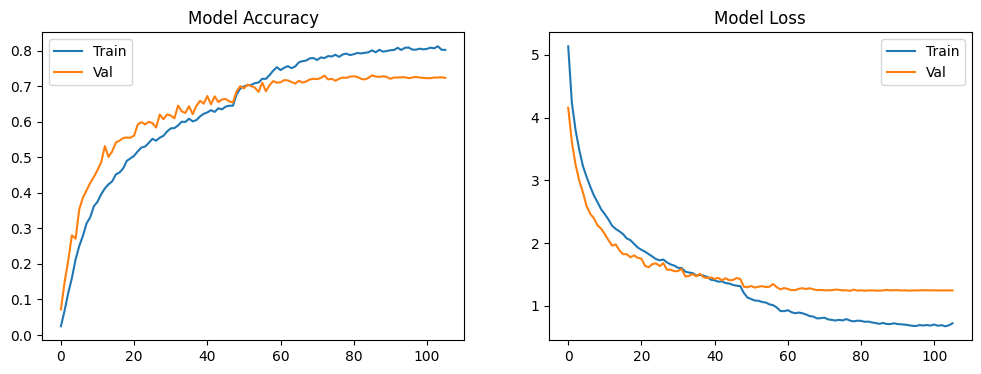

2025-12-17 01:05:02.061454: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44154000 exceeds 10% of free system memory.


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step

Classification Report:
              precision    recall  f1-score   support

      animal       0.43      0.60      0.50        10
         arm       0.80      0.73      0.76        11
      arrest       0.70      0.70      0.70        10
        baby       0.70      0.70      0.70        10
      banana       0.76      0.93      0.84        14
        bark       0.56      1.00      0.71        10
  basketball       1.00      0.91      0.95        11
         bat       1.00      0.70      0.82        10
         bow       0.91      0.83      0.87        12
         bra       1.00      1.00      1.00        10
       break       0.22      0.20      0.21        10
        bury       1.00      0.85      0.92        13
        call       0.50      0.67      0.57         9
       candy       0.86      0.60      0.71        10
      carrot       0.69      1.00      0.81        11
      castle       0.91      0.83      0.87        12
         cat     

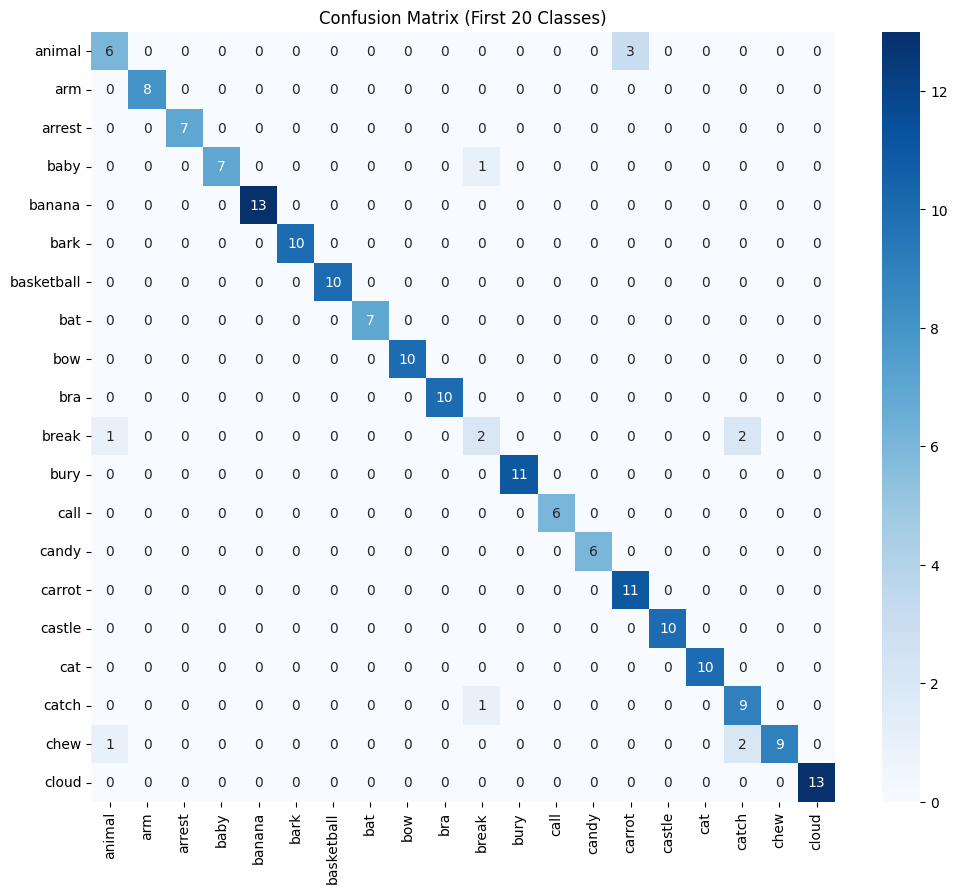

In [ ]:
# ===============================
# Evaluation & Visualization
# ===============================
print("\n>>> Evaluating on Test Set...")
loss, acc = model.evaluate(X_test, y_test)
print(f"Final Test Accuracy: {acc * 100:.2f}%")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Model Loss')
plt.legend()
plt.show()

# تقرير التصنيف (Classification Report)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# تجهيز أسماء الكلاسات للتقرير
# عكس القاموس {0: 'word', ...}
id_to_label = {v: k for k, v in label_map.items()}
class_names = [id_to_label[i] for i in range(len(label_map))]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix (مبسطة لأول 20 كلمة عشان الزحمة)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(
    cm[:20, :20], # عرضنا أول 20 كلمة بس عشان الصورة متسحمش
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names[:20],
    yticklabels=class_names[:20]
)
plt.title("Confusion Matrix (First 20 Classes)")
plt.show()